<a href="https://colab.research.google.com/github/JRicLP/Pipeline-ML-ANS/blob/main/joao_ricardo_custo_educacional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [108]:
#Bibliotecas usadas:
try:
  import gdown
except ImportError:
  !pip install gdown
  import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, silhouette_score
from sklearn.utils import resample
from sklearn.decomposition import PCA

In [109]:
plt.style.use('ggplot')
sns.set(style="whitegrid")

file_id = '1GBru39-ASKE52R8gpEZrVwlROPRwXtAw'
dataset_url = f'https://drive.google.com/uc?id={file_id}'

# Definir nome do arquivo:
output_path = 'credit_data.csv'

# Baixar o arquivo usando gdown:
print(f"Baixando o dataset do Google Drive...")
gdown.download(dataset_url, output_path, quiet=False)

Baixando o dataset do Google Drive...


Downloading...
From: https://drive.google.com/uc?id=1GBru39-ASKE52R8gpEZrVwlROPRwXtAw
To: /content/credit_data.csv
100%|██████████| 84.1k/84.1k [00:00<00:00, 4.94MB/s]


'credit_data.csv'

In [110]:
# Carregando o arquivo:
try:
    with open(output_path, 'r') as file:
        first_line = file.readline().strip()

    if ',' in first_line and ';' not in first_line:
        dataset = pd.read_csv(output_path, sep=None, engine='python')
    else:
        dataset = pd.read_csv(output_path, sep=';')

        if dataset.shape[1] == 1:
            first_col_name = dataset.columns[0]
            temp_df = dataset[first_col_name].str.split(',', expand=True)

            if 'Country' in first_col_name or 'ID' in first_col_name:
                header = first_col_name.split(',')
                if len(header) < temp_df.shape[1]:
                    for i in range(len(header), temp_df.shape[1]):
                        header.append(f'Column_{i}')
                temp_df.columns = header

            dataset = temp_df

    print("Dataset carregado com sucesso!")
except Exception as e:
    print(f"Erro ao carregar o dataset: {e}")
    print("Tentando outro método de carregamento...")
    try:
        dataset = pd.read_csv(output_path, sep=None, engine='python')
        print("Dataset carregado com sucesso usando detecção automática de separador!")
    except Exception as e2:
        print(f"Erro final ao carregar o dataset: {e2}")

# Verificando se as colunas estão corretamente separadas:
print("\nVerificando estrutura do dataset...")
print(f"Número de colunas: {dataset.shape[1]}")
print(f"Nomes das colunas: {dataset.columns.tolist()}")

for col in dataset.columns:
    if col not in ['Country', 'City', 'University', 'Program', 'Level'] and 'ID' not in col:
        try:
            dataset[col] = pd.to_numeric(dataset[col], errors='coerce')
        except:
            pass

# Verificando se há colunas numéricas para prosseguir com a análise:
numeric_cols = dataset.select_dtypes(include=['number']).columns
print(f"\nColunas numéricas disponíveis: {numeric_cols.tolist()}")

if len(numeric_cols) == 0:
    print("ERRO: Não foram encontradas colunas numéricas no dataset.")
    print("Verifique o formato do arquivo CSV e o separador usado.")
    print("Criando colunas numéricas artificiais para teste...")
    dataset['Valor_1'] = np.random.uniform(0, 100, size=len(dataset))
    dataset['Valor_2'] = np.random.uniform(0, 200, size=len(dataset))
    dataset['Valor_3'] = np.random.uniform(0, 50, size=len(dataset))
    numeric_cols = ['Valor_1', 'Valor_2', 'Valor_3']

Dataset carregado com sucesso!

Verificando estrutura do dataset...
Número de colunas: 12
Nomes das colunas: ['Country', 'City', 'University', 'Program', 'Level', 'Duration_Years', 'Tuition_USD', 'Living_Cost_Index', 'Rent_USD', 'Visa_Fee_USD', 'Insurance_USD', 'Exchange_Rate']

Colunas numéricas disponíveis: ['Duration_Years', 'Tuition_USD', 'Living_Cost_Index', 'Rent_USD', 'Visa_Fee_USD', 'Insurance_USD', 'Exchange_Rate']


In [111]:
# Verificando e convertendo tipos de dados após carregar o dataset:
numeric_columns = ['Duration_Years', 'Tuition_USD', 'Living_Cost_Index',
                  'Rent_USD', 'Visa_Fee_USD', 'Insurance_USD', 'Exchange_Rate']

for col in numeric_columns:
    if col in dataset.columns:
        dataset[col] = pd.to_numeric(dataset[col], errors='coerce')

# Verificando os tipos após a conversão:
print("\nTipos de dados após conversão:")
print(dataset.dtypes)

# Exibindo o DataFrame:
print("\nPrimeiras Linhas do Dataset:")
print(dataset.head().to_string())

# Obtendo informações gerais do dataset:
print("\nInformações Gerais do Dataset:")
dataset.info()

# Exibindo o número de linhas e colunas:
print(f"\nDimensões do Dataset: {dataset.shape} (Linhas, Colunas)")

# Exibindo o nome das colunas:
print("\nNomes das Colunas:")
print(dataset.columns.tolist())

# Checando os dados ausentes por coluna, caso tenha:
print("\nDados Ausentes por Coluna:")
print(dataset.isnull().sum())

# Exibindo tipos de dados de cada coluna:
print("\nTipos de Dados das Colunas:")
print(dataset.dtypes)

# Exibindo estatísticas descritivas para colunas numéricas:
print("\nEstatísticas Descritivas das Colunas Numéricas:")
print(dataset.describe().to_string())


Tipos de dados após conversão:
Country               object
City                  object
University            object
Program               object
Level                 object
Duration_Years       float64
Tuition_USD            int64
Living_Cost_Index    float64
Rent_USD               int64
Visa_Fee_USD           int64
Insurance_USD          int64
Exchange_Rate        float64
dtype: object

Primeiras Linhas do Dataset:
     Country       City                      University                 Program   Level  Duration_Years  Tuition_USD  Living_Cost_Index  Rent_USD  Visa_Fee_USD  Insurance_USD  Exchange_Rate
0        USA  Cambridge              Harvard University        Computer Science  Master             2.0        55400               83.5      2200           160           1500           1.00
1         UK     London         Imperial College London            Data Science  Master             1.0        41200               75.8      1800           485            800           0.79
2     


Gerando visualizações da Análise Exploratória...


/tmp/ipython-input-3678769585.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


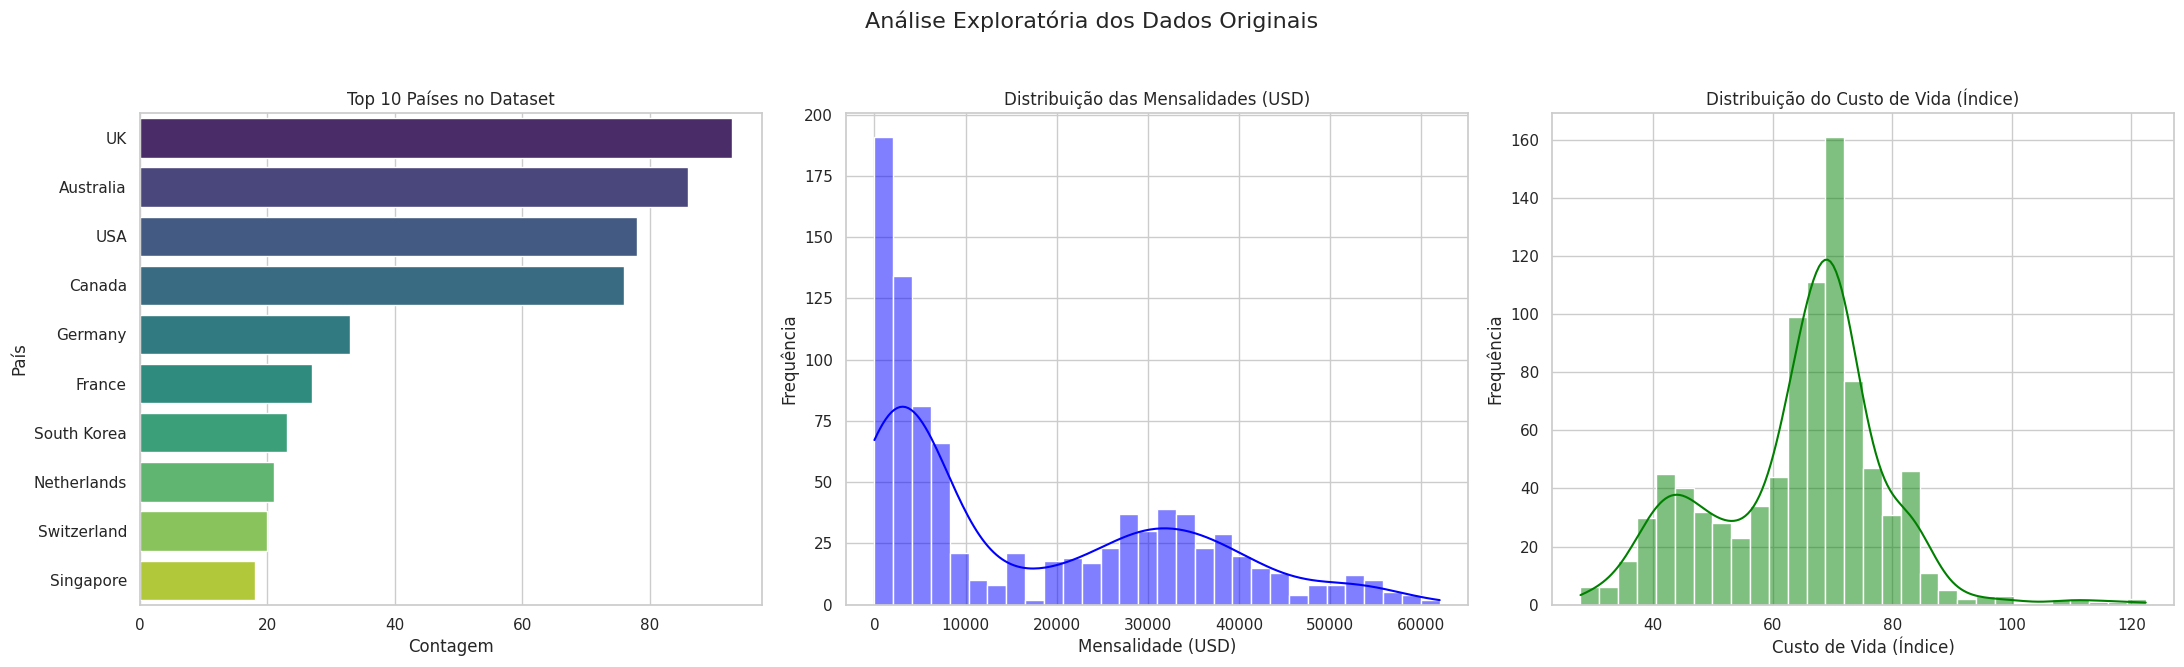

Gráficos de EDA salvos em 'eda_plots.png'


In [112]:
#Análise Exploratória (EDA)

print("\nGerando visualizações da Análise Exploratória...")

# Criar uma figura com 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(22, 7))
fig.suptitle('Análise Exploratória dos Dados Originais', fontsize=16)

# Gráfico 1: Top 10 Países
sns.countplot(
    y=dataset['Country'],
    ax=axes[0],
    order=dataset['Country'].value_counts().iloc[:10].index,
    palette='viridis'
)
axes[0].set_title('Top 10 Países no Dataset')
axes[0].set_xlabel('Contagem')
axes[0].set_ylabel('País')

# Gráfico 2: Distribuição das Mensalidades (Tuition_USD)
sns.histplot(
    dataset['Tuition_USD'],
    kde=True,
    ax=axes[1],
    color='blue',
    bins=30
)
axes[1].set_title('Distribuição das Mensalidades (USD)')
axes[1].set_xlabel('Mensalidade (USD)')
axes[1].set_ylabel('Frequência')

# Gráfico 3: Distribuição do Custo de Vida
sns.histplot(
    dataset['Living_Cost_Index'],
    kde=True,
    ax=axes[2],
    color='green',
    bins=30
)
axes[2].set_title('Distribuição do Custo de Vida (Índice)')
axes[2].set_xlabel('Custo de Vida (Índice)')
axes[2].set_ylabel('Frequência')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('eda_plots.png')
plt.show()
plt.close()

print("Gráficos de EDA salvos em 'eda_plots.png'")

In [113]:
# 2. Pré-processamento dos dados:

# Identificando colunas numéricas:
numeric_columns = dataset.select_dtypes(include=['number']).columns.tolist()

# Tratamento de valores nulos
for col in dataset.columns:
    if dataset[col].isnull().sum() > 0:
        if col in numeric_columns:
            if 'ID' in col:
                dataset[col] = dataset[col].fillna(dataset[col].max() + 1)
            elif 'Idade' in col:
                dataset[col] = dataset[col].fillna(dataset[col].mode()[0])
            elif 'Renda' in col or 'Valor' in col:
                dataset[col] = dataset[col].fillna(dataset[col].mean())
            elif 'Pontuacao' in col:
                dataset[col] = dataset[col].fillna(dataset[col].max())
            else:
                dataset[col] = dataset[col].fillna(dataset[col].mean())
        else:
            dataset[col] = dataset[col].fillna(dataset[col].mode()[0])

print("Valores nulos após tratamento:")
print(dataset.isnull().sum())

# Detecção de outliers
print("\nDetectando outliers...")
limite = 1.5
numeric_cols = dataset.select_dtypes(include='number')
outlier_counts = 0
total_values = numeric_cols.size

for col in numeric_cols.columns:
    if 'ID' not in col:
        Q1 = numeric_cols[col].quantile(0.25)
        Q3 = numeric_cols[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - limite * IQR
        upper_bound = Q3 + limite * IQR
        col_outliers = numeric_cols[(numeric_cols[col] < lower_bound) | (numeric_cols[col] > upper_bound)][col].count()
        outlier_counts += col_outliers
        print(f"Coluna '{col}' - Outliers: {col_outliers} ({(col_outliers / len(dataset) * 100):.2f}%)")

if total_values > 0:
    outlier_percentage = (outlier_counts / total_values) * 100
    print(f"\nPercentual de contaminação de outliers no dataset: {outlier_percentage:.2f}%")
else:
    print("\nNenhuma coluna numérica encontrada para detecção de outliers.")

# Visualização de outliers
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols.columns):
    if 'ID' not in col and i < 9:
        plt.subplot(3, 3, i + 1)
        plt.boxplot(dataset[col])
        plt.title(col)
plt.tight_layout()
plt.savefig('boxplots.png')
plt.close()
print("Boxplots das features numéricas salvos em 'boxplots.png'")

# Tratamento dos outliers
print("\nTratando outliers através de winsorização...")
for col in numeric_cols.columns:
    if 'ID' not in col:
        Q1 = numeric_cols[col].quantile(0.25)
        Q3 = numeric_cols[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - limite * IQR
        upper_bound = Q3 + limite * IQR
        dataset[col] = np.where(dataset[col] < lower_bound, lower_bound, dataset[col])
        dataset[col] = np.where(dataset[col] > upper_bound, upper_bound, dataset[col])
print("Outliers tratados com sucesso.")

# 2.5. Codificação de Features Categóricas
# Esta etapa é essencial para que os algoritmos de ML possam processar as colunas de texto.

print("\n2.5. Codificando features categóricas (texto)...")
categorical_columns = dataset.select_dtypes(include=['object']).columns

# Vamos guardar os "LabelEncoders" para usar depois em novos dados
encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    dataset[col] = le.fit_transform(dataset[col])
    encoders[col] = le # Salva o encoder treinado
    print(f"Coluna '{col}' codificada com LabelEncoder.")

print("\nDataset após codificação categórica:")
print(dataset.head().to_string())

print("\nTipos de dados finais (prontos para ML):")
print(dataset.dtypes)

Valores nulos após tratamento:
Country              0
City                 0
University           0
Program              0
Level                0
Duration_Years       0
Tuition_USD          0
Living_Cost_Index    0
Rent_USD             0
Visa_Fee_USD         0
Insurance_USD        0
Exchange_Rate        0
dtype: int64

Detectando outliers...
Coluna 'Duration_Years' - Outliers: 0 (0.00%)
Coluna 'Tuition_USD' - Outliers: 0 (0.00%)
Coluna 'Living_Cost_Index' - Outliers: 20 (2.21%)
Coluna 'Rent_USD' - Outliers: 3 (0.33%)
Coluna 'Visa_Fee_USD' - Outliers: 93 (10.25%)
Coluna 'Insurance_USD' - Outliers: 78 (8.60%)
Coluna 'Exchange_Rate' - Outliers: 169 (18.63%)

Percentual de contaminação de outliers no dataset: 5.72%
Boxplots das features numéricas salvos em 'boxplots.png'

Tratando outliers através de winsorização...
Outliers tratados com sucesso.

2.5. Codificando features categóricas (texto)...
Coluna 'Country' codificada com LabelEncoder.
Coluna 'City' codificada com LabelEncoder.
Coluna

In [114]:
# 3. Normalização dos dados

# Normalizando colunas:
columns_to_normalize = [col for col in numeric_cols if 'ID' not in col]
if 'Pontuacao_Credito' in dataset.columns:
    potential_target = 'Pontuacao_Credito'
    if potential_target in columns_to_normalize:
        columns_to_normalize.remove(potential_target)

# Aplicando normalização Min-Max:
scaler = MinMaxScaler()

# Normalizando apenas as colunas selecionadas:
dataset[columns_to_normalize] = scaler.fit_transform(dataset[columns_to_normalize])

print(f"Normalização aplicada às seguintes colunas: {columns_to_normalize}")
print("\nPrimeiras linhas após normalização:")
print(dataset.head().to_string())

Normalização aplicada às seguintes colunas: ['Duration_Years', 'Tuition_USD', 'Living_Cost_Index', 'Rent_USD', 'Visa_Fee_USD', 'Insurance_USD', 'Exchange_Rate']

Primeiras linhas após normalização:
   Country  City  University  Program  Level  Duration_Years  Tuition_USD  Living_Cost_Index  Rent_USD  Visa_Fee_USD  Insurance_USD  Exchange_Rate
0       66    84         101       17      1            0.25     0.893548           0.802673  0.898138      0.292683       1.000000       0.052004
1       65   283         128       27      1            0.00     0.664516           0.681604  0.722892      1.000000       0.533333       0.039156
2        9   503         572        9      1            0.25     0.620968           0.629717  0.635268      0.475610       0.622222       0.073417
3        2   313         495       44      1            0.25     0.677419           0.609277  0.547645      1.000000       0.400000       0.083818
4       22   330         307       66      1            0.25     0.


4.1. Preparando dados para clustering...
Colunas usadas para clustering: ['Tuition_USD', 'Living_Cost_Index', 'Rent_USD', 'Visa_Fee_USD', 'Insurance_USD']
Normalizando dados para o KMeans...
Gerando visualização PCA...
Visualização PCA salva em 'pca_before_clustering.png'
Determinando número ideal de clusters (K)...
Para 2 clusters, o silhouette score é: 0.4333
Para 3 clusters, o silhouette score é: 0.4843
Para 4 clusters, o silhouette score é: 0.4762
Para 5 clusters, o silhouette score é: 0.4868
Para 6 clusters, o silhouette score é: 0.4921
Para 7 clusters, o silhouette score é: 0.4493
Para 8 clusters, o silhouette score é: 0.5010
Para 9 clusters, o silhouette score é: 0.4309
Para 10 clusters, o silhouette score é: 0.4060
Gráfico do método do cotovelo salvo em 'elbow_method.png'

Número ideal de clusters (sugestão do Silhouette): 8
SUBSTITUINDO: Usando k=4 clusters fixos para melhor interpretação.

4.3. Realizando clustering com 4 clusters...
Clusters atribuídos ao dataset.
Visualiza

/tmp/ipython-input-3193785195.py:146: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-3193785195.py:160: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


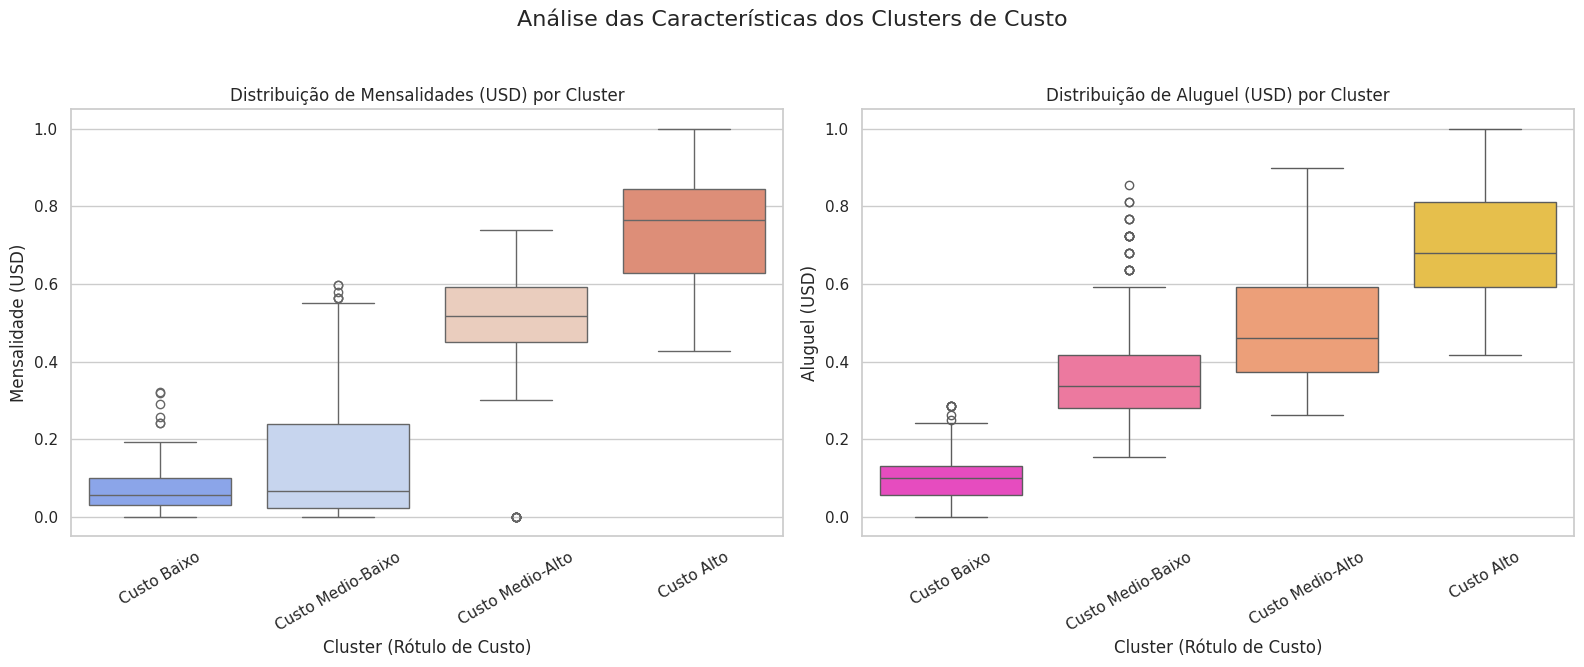

Gráficos de Análise de Cluster salvos em 'cluster_analysis_plots.png'


In [115]:
# 4. Aprendizado Semi-Supervisionado com KMeans:

# 4.1. Definindo features para clustering:
print("\n4.1. Preparando dados para clustering...")

# Definir explicitamente as colunas para o cluster (perfil de custo)
cluster_columns = ['Tuition_USD', 'Living_Cost_Index', 'Rent_USD', 'Visa_Fee_USD', 'Insurance_USD']
print(f"Colunas usadas para clustering: {cluster_columns}")

X_cluster_raw = dataset[cluster_columns].copy()

# Normalização
print("Normalizando dados para o KMeans...")
scaler_cluster = MinMaxScaler()
X_cluster_normalized = scaler_cluster.fit_transform(X_cluster_raw)
# Salvar o scaler
with open('kmeans_scaler.pkl', 'wb') as f:
    pickle.dump(scaler_cluster, f)

# Visualizando os dados (PCA com dados normalizados)
print("Gerando visualização PCA...")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster_normalized)

plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6)
plt.title('Visualização dos dados (Custos Normalizados) com PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.savefig('pca_before_clustering.png')
plt.close()
print("Visualização PCA salva em 'pca_before_clustering.png'")


# 4.2. Determinando o número ideal de clusters:
print("Determinando número ideal de clusters (K)...")
inertia = []
silhouette_scores = []
max_clusters = min(10, len(dataset) - 1)

for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_cluster_normalized)
    inertia.append(kmeans.inertia_)

    if k > 1:
        silhouette_avg = silhouette_score(X_cluster_normalized, kmeans.labels_)
        silhouette_scores.append(silhouette_avg)
        print(f"Para {k} clusters, o silhouette score é: {silhouette_avg:.4f}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(2, max_clusters + 1), inertia, 'bo-')
plt.title('Método do Cotovelo')
plt.xlabel('Número de Clusters')
plt.ylabel('Inertia')
plt.subplot(1, 2, 2)
plt.plot(range(2, max_clusters + 1), silhouette_scores, 'ro-')
plt.title('Silhouette Score')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.tight_layout()
plt.savefig('elbow_method.png')
plt.close()
print("Gráfico do método do cotovelo salvo em 'elbow_method.png'")

# Escolhendo o número de clusters com base no maior silhouette score:
optimal_k_sugestao = silhouette_scores.index(max(silhouette_scores)) + 2
print(f"\nNúmero ideal de clusters (sugestão do Silhouette): {optimal_k_sugestao}")

# Substituir pelo valor fixo para melhor interpretação de negócio
optimal_k = 4
print(f"SUBSTITUINDO: Usando k={optimal_k} clusters fixos para melhor interpretação.")

# 4.3. Realizando o clustering com o número ideal de clusters:
print(f"\n4.3. Realizando clustering com {optimal_k} clusters...")
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_cluster_normalized)

dataset['Cluster'] = clusters
print("Clusters atribuídos ao dataset.")

plt.figure(figsize=(12, 10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.8)
plt.title(f'Visualização dos {optimal_k} Clusters com PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Cluster')
plt.savefig('clusters_pca.png')
plt.close()
print("Visualização dos clusters salva em 'clusters_pca.png'")


# 4.4. Analisando características de cada cluster:
print("\n4.4. Analisando características de cada cluster...")
# Usar valores originais (não-normalizados) para entender o significado
cluster_analysis = dataset.groupby('Cluster')[cluster_columns].mean()
print("\nMédia das features de CUSTO por cluster (valores originais):")
print(cluster_analysis.to_string())


# 4.5. Rotulando os clusters semanticamente
print("\n4.5. Atribuindo rótulos semânticos (baseados em Custo)...")

# Calcular uma pontuação de "custo"
cluster_analysis['Custo_Total_Medio'] = cluster_analysis['Tuition_USD'] + cluster_analysis['Rent_USD']

# Ordenar os clusters pelo custo total, do menor para o maior
sorted_clusters_by_cost = cluster_analysis.sort_values(by='Custo_Total_Medio').index

# Definir rótulos significativos
if optimal_k == 4:
    cost_labels = ['Custo Baixo', 'Custo Medio-Baixo', 'Custo Medio-Alto', 'Custo Alto']
elif optimal_k == 3:
    cost_labels = ['Custo Baixo', 'Custo Medio', 'Custo Alto']
else: # Fallback genérico (não deve ser usado agora)
    cost_labels = [f"Nivel_Custo_{i}" for i in range(optimal_k)]

# Mapear os IDs dos clusters ordenados para os rótulos de custo
semantic_labels = {}
for i, cluster_id in enumerate(sorted_clusters_by_cost):
    semantic_labels[cluster_id] = cost_labels[i]

print("\nAtribuição de rótulos de Custo aos clusters:")
for cluster_id, label in semantic_labels.items():
    print(f"Cluster {cluster_id}: {label}")

# Adicionando os rótulos semânticos ao dataset:
dataset['Rotulo_Custo'] = dataset['Cluster'].map(semantic_labels)

# Exibindo a distribuição dos rótulos semânticos:
print("\nDistribuição dos rótulos de custo:")
print(dataset['Rotulo_Custo'].value_counts())

#Análise dos Clusters

print("\nGerando visualizações da Análise de Clusters...")

cluster_order = ['Custo Baixo', 'Custo Medio-Baixo', 'Custo Medio-Alto', 'Custo Alto']

# Criar uma figura com 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('Análise das Características dos Clusters de Custo', fontsize=16)

# Mensalidades por Cluster
sns.boxplot(
    x='Rotulo_Custo',
    y='Tuition_USD',
    data=dataset,
    ax=axes[0],
    order=cluster_order,
    palette='coolwarm'
)
axes[0].set_title('Distribuição de Mensalidades (USD) por Cluster')
axes[0].set_xlabel('Cluster (Rótulo de Custo)')
axes[0].set_ylabel('Mensalidade (USD)')
axes[0].tick_params(axis='x', rotation=30)

# Gráfico 2: Aluguel por Cluster
sns.boxplot(
    x='Rotulo_Custo',
    y='Rent_USD',
    data=dataset,
    ax=axes[1],
    order=cluster_order,
    palette='spring'
)
axes[1].set_title('Distribuição de Aluguel (USD) por Cluster')
axes[1].set_xlabel('Cluster (Rótulo de Custo)')
axes[1].set_ylabel('Aluguel (USD)')
axes[1].tick_params(axis='x', rotation=30)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('cluster_analysis_plots.png')
plt.show()
plt.close()

print("Gráficos de Análise de Cluster salvos em 'cluster_analysis_plots.png'")


Target (y) para classificação: 'Rotulo_Custo'
Features (X) para classificação: ['Country', 'City', 'University', 'Program', 'Level', 'Duration_Years']

Rótulos do Target codificados (ex: 'Custo Alto' -> 0)

Distribuição das classes (Target: Rotulo_Custo):
Rotulo_Custo
Custo Medio-Baixo    343
Custo Baixo          256
Custo Medio-Alto     210
Custo Alto            98
Name: count, dtype: int64

Detectado desbalanceamento. Aplicando downsampling...

Distribuição das classes após balanceamento (rótulos codificados):
Rotulo_Custo
0    98
1    98
2    98
3    98
Name: count, dtype: int64

Tamanho do conjunto de treino: 313 exemplos
Tamanho do conjunto de teste: 79 exemplos
Tipo de y_train: int64

5.3.1. Treinando modelo SVM...
Modelo SVM treinado com sucesso!

Métricas do modelo SVM:
Acurácia: 0.4304
Precisão: 0.7898
Recall: 0.4304
F1-Score: 0.3995

5.3.2. Treinando modelo MLP...
Modelo MLP treinado com sucesso!

Métricas do modelo MLP:
Acurácia: 0.2278
Precisão: 0.2052
Recall: 0.2278
F1-Sc

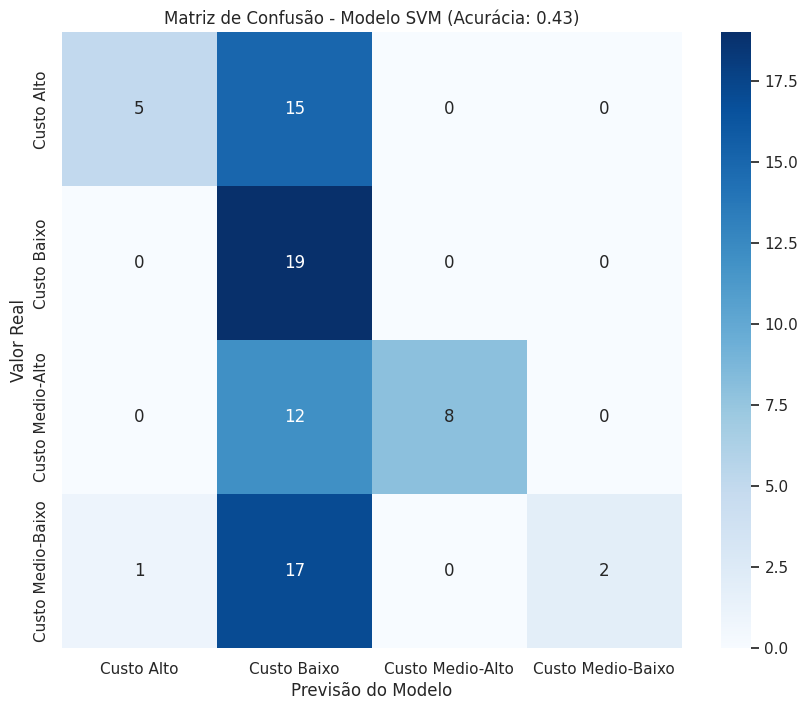

Matriz de Confusão salva em 'svm_confusion_matrix.png'

Calculando Importância das Features (usando RandomForest)...


/tmp/ipython-input-408332730.py:184: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


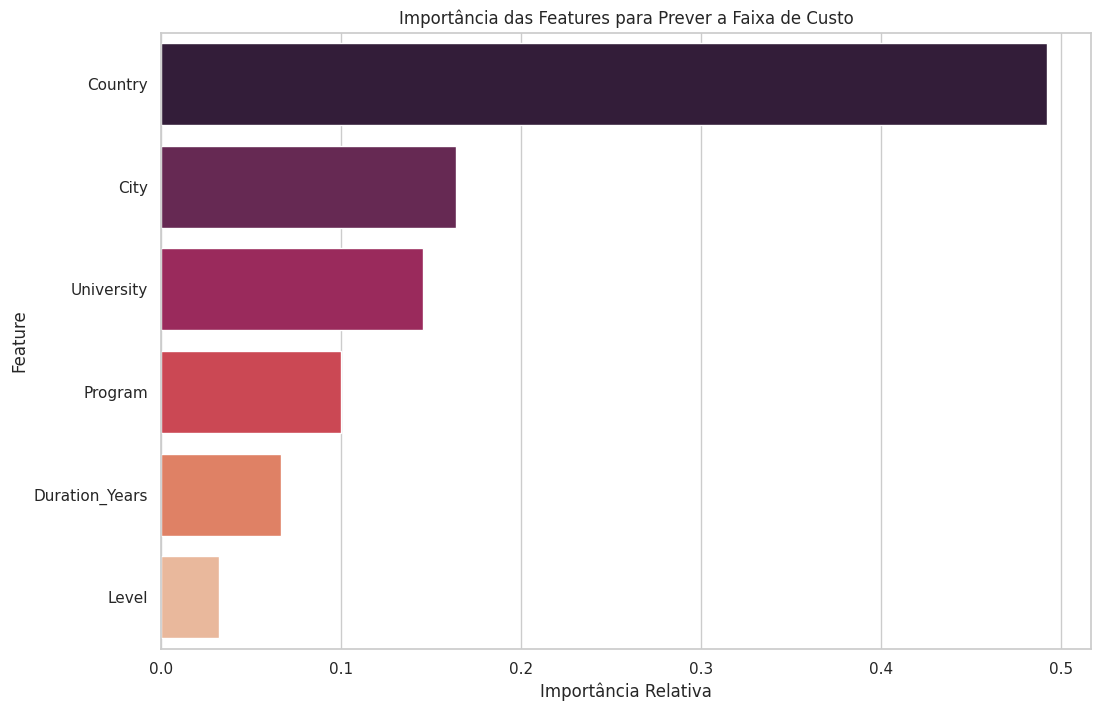

Gráfico de Importância das Features salvo em 'feature_importance.png'


In [116]:
# 5. Classificação utilizando os rótulos atribuídos

# Definindo Target e Features
target_column = 'Rotulo_Custo'
target = dataset[target_column]

cost_columns = ['Tuition_USD', 'Living_Cost_Index', 'Rent_USD', 'Visa_Fee_USD', 'Insurance_USD', 'Exchange_Rate']
utility_columns = ['Cluster', target_column]
features = dataset.drop(columns = cost_columns + utility_columns)

print(f"\nTarget (y) para classificação: '{target_column}'")
print(f"Features (X) para classificação: {features.columns.tolist()}")

# O MLPClassifier requer que os rótulos (y) sejam numéricos
le_target = LabelEncoder()
target_encoded = le_target.fit_transform(target)
print(f"\nRótulos do Target codificados (ex: '{target[0]}' -> {target_encoded[0]})")
# Salvar o encoder do target para usar nas Células 6 e 7
with open('target_label_encoder.pkl', 'wb') as f:
    pickle.dump(le_target, f)

# Verificando se há classes desbalanceadas:
# Usamos o 'target' original (strings) para contagem, pois é mais legível
print(f"\nDistribuição das classes (Target: {target_column}):")
class_distribution = target.value_counts()
print(class_distribution)

# Balanceando o dataset (Downsampling)
if class_distribution.min() / class_distribution.max() < 0.5:
    print("\nDetectado desbalanceamento. Aplicando downsampling...")

    # Precisamos adicionar o target codificado ao features para o resample
    features_with_target = features.copy()
    features_with_target[target_column] = target_encoded

    minority_class_label = class_distribution.idxmin()
    # Mapear o rótulo da string (minoria) para seu valor codificado
    minority_class_encoded = le_target.transform([minority_class_label])[0]
    n_samples_minority = class_distribution.min()
    balanced_df_list = []

    # Usamos o target_encoded (0, 1, 2...) para o loop
    for class_label_encoded in np.unique(target_encoded):
        class_data = features_with_target[features_with_target[target_column] == class_label_encoded]

        if class_label_encoded == minority_class_encoded:
            balanced_df_list.append(class_data)
        else:
            downsampled_class_data = resample(class_data,
                                             replace=False,
                                             n_samples=n_samples_minority,
                                             random_state=42)
            balanced_df_list.append(downsampled_class_data)

    balanced_dataset = pd.concat(balanced_df_list).reset_index(drop=True)

    # Atualizando target e features com base no dataset balanceado
    target_final = balanced_dataset[target_column]
    features_final = balanced_dataset.drop(columns=[target_column])

    print("\nDistribuição das classes após balanceamento (rótulos codificados):")
    print(target_final.value_counts())
else:
    print("\nDataset está suficientemente balanceado.")
    target_final = target_encoded
    features_final = features


# 5.2. Dividindo em conjuntos de Treino e Teste:
X_train, X_test, y_train, y_test = train_test_split(
    features_final, target_final, test_size=0.2, random_state=42, stratify=target_final
)
print(f"\nTamanho do conjunto de treino: {X_train.shape[0]} exemplos")
print(f"Tamanho do conjunto de teste: {X_test.shape[0]} exemplos")
print(f"Tipo de y_train: {y_train.dtype}")


# 5.3 Support Vector Machine (SVM)
print("\n5.3.1. Treinando modelo SVM...")
svm_model = SVC(kernel='rbf', C=1.0, gamma='auto', random_state=42)
svm_model.fit(X_train, y_train)
print("Modelo SVM treinado com sucesso!")
y_pred_svm = svm_model.predict(X_test)

# Métricas
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm, average='weighted', zero_division=0)
recall_svm = recall_score(y_test, y_pred_svm, average='weighted')
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')

print("\nMétricas do modelo SVM:")
print(f"Acurácia: {accuracy_svm:.4f}")
print(f"Precisão: {precision_svm:.4f}")
print(f"Recall: {recall_svm:.4f}")
print(f"F1-Score: {f1_svm:.4f}")


# 5.3.2. Multi-Layer Perceptron (MLP):
print("\n5.3.2. Treinando modelo MLP...")
mlp_model = MLPClassifier(
    hidden_layer_sizes=(100,),
    activation='relu',
    solver='adam',
    max_iter=1000,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1
)
mlp_model.fit(X_train, y_train)
print("Modelo MLP treinado com sucesso!")

# Predições
y_pred_mlp = mlp_model.predict(X_test)

# Métricas
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
precision_mlp = precision_score(y_test, y_pred_mlp, average='weighted', zero_division=0)
recall_mlp = recall_score(y_test, y_pred_mlp, average='weighted')
f1_mlp = f1_score(y_test, y_pred_mlp, average='weighted')

print("\nMétricas do modelo MLP:")
print(f"Acurácia: {accuracy_mlp:.4f}")
print(f"Precisão: {precision_mlp:.4f}")
print(f"Recall: {recall_mlp:.4f}")
print(f"F1-Score: {f1_mlp:.4f}")

# 5.4. Salvando modelos:
print("\n5.4. Salvando modelos treinados...")
with open('svm_model_corrected.pkl', 'wb') as f:
    pickle.dump(svm_model, f)
print("Modelo SVM salvo como 'svm_model_corrected.pkl'")

with open('mlp_model_corrected.pkl', 'wb') as f:
    pickle.dump(mlp_model, f)
print("Modelo MLP salvo como 'mlp_model_corrected.pkl'")

# Análise do Modelo de Classificação
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

print("\nGerando visualizações da Análise do Modelo...")

# Gráfico 1: Matriz de Confusão (SVM)
try:
    with open('target_label_encoder.pkl', 'rb') as f:
        le_target = pickle.load(f)
    class_names = le_target.classes_

    # Calcular a matriz de confusão
    cm = confusion_matrix(y_test, y_pred_svm)
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusão - Modelo SVM (Acurácia: {accuracy_svm:.2f})')
    plt.xlabel('Previsão do Modelo')
    plt.ylabel('Valor Real')
    plt.savefig('svm_confusion_matrix.png')
    plt.show()
    plt.close()
    print("Matriz de Confusão salva em 'svm_confusion_matrix.png'")

except Exception as e:
    print(f"Erro ao gerar matriz de confusão: {e}")


# Gráfico 2: Importância das Features
print("\nCalculando Importância das Features (usando RandomForest)...")
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Obtendo as importâncias
importances = rf_model.feature_importances_
feature_names = X_train.columns

# Criando um DataFrame para facilitar a plotagem
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plotando
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance_df,
    palette='rocket'
)
plt.title('Importância das Features para Prever a Faixa de Custo')
plt.xlabel('Importância Relativa')
plt.ylabel('Feature')
plt.savefig('feature_importance.png')
plt.show()
plt.close()
print("Gráfico de Importância das Features salvo em 'feature_importance.png'")

In [117]:
# 6. Aplicação em dados não rotulados

# O objetivo é usar os modelos para prever a FAIXA DE CUSTO de novos dados.

X_unlabeled = X_test.iloc[:5].copy()
y_real_encoded = y_test.iloc[:5].copy()

print("\n6.1. Aplicando os classificadores treinados em 5 amostras de teste...")

# Carregando o Encoder do Target
try:
    with open('target_label_encoder.pkl', 'rb') as f:
        le_target = pickle.load(f)
    print("Encoder de rótulos (target) carregado com sucesso.")
except FileNotFoundError:
    print("ERRO: Arquivo 'target_label_encoder.pkl' não encontrado.")
    print("Por favor, rode a Célula 5 novamente para criar o arquivo.")
    le_target = LabelEncoder()
    le_target.fit(['Fallback_Label_1', 'Fallback_Label_2'])

# 1. Prevendo classes (Faixa de Custo) utilizando os modelos treinados:
try:
    # Modelos preveem os rótulos numéricos
    svm_predictions_encoded = svm_model.predict(X_unlabeled)
    mlp_predictions_encoded = mlp_model.predict(X_unlabeled)
    print("Predições (numéricas) realizadas com sucesso.")

    # Traduzir previsões numéricas para texto
    svm_predictions = le_target.inverse_transform(svm_predictions_encoded)
    mlp_predictions = le_target.inverse_transform(mlp_predictions_encoded)
    # Traduzir também os valores reais para a tabela de comparação
    y_real = le_target.inverse_transform(y_real_encoded)
    print("Previsões traduzidas de volta para texto (ex: 'Custo Alto').")

except Exception as e:
    print(f"Erro inesperado durante a predição ou tradução: {e}")
    svm_predictions = ["ERRO"] * len(X_unlabeled)
    mlp_predictions = ["ERRO"] * len(X_unlabeled)
    y_real = ["ERRO"] * len(X_unlabeled)


# 2. Exibindo os resultados de forma clara
print("\n--- Previsões de FAIXA DE CUSTO para novos dados ---")
print("-" * 70)
print(f"{'Exemplo':<10} | {'Previsão SVM':<18} | {'Previsão MLP':<18} | {'Valor Real':<18}")
print("-" * 70)

# Iterar usando os índices para garantir o alinhamento
for i in range(len(X_unlabeled)):
    svm_pred = svm_predictions[i]
    mlp_pred = mlp_predictions[i]
    real_val = y_real[i]

    print(f"{i+1:<10} | {svm_pred:<18} | {mlp_pred:<18} | {real_val:<18}")


6.1. Aplicando os classificadores treinados em 5 amostras de teste...
Encoder de rótulos (target) carregado com sucesso.
Predições (numéricas) realizadas com sucesso.
Previsões traduzidas de volta para texto (ex: 'Custo Alto').

--- Previsões de FAIXA DE CUSTO para novos dados ---
----------------------------------------------------------------------
Exemplo    | Previsão SVM       | Previsão MLP       | Valor Real        
----------------------------------------------------------------------
1          | Custo Alto         | Custo Baixo        | Custo Alto        
2          | Custo Medio-Alto   | Custo Baixo        | Custo Medio-Alto  
3          | Custo Baixo        | Custo Alto         | Custo Medio-Baixo 
4          | Custo Baixo        | Custo Baixo        | Custo Medio-Baixo 
5          | Custo Baixo        | Custo Baixo        | Custo Medio-Baixo 


In [118]:
# 7. Conclusão

print("\n\n7. Conclusão")

try:
    print(f"Foram identificados {optimal_k} clusters de CUSTO, que foram mapeados para:")

    # Nosso 'semantic_labels' é um dict simples: {cluster_id: 'label_string'}
    for cluster_id, label in semantic_labels.items():
        print(f" - Cluster {cluster_id}: {label}")

except Exception as e:
    print(f"Erro ao exibir informações de clusters: {str(e)}")
    print("Verifique se as variáveis 'optimal_k' e 'semantic_labels' da Célula 4 existem.")


print("\nDesempenho dos modelos de classificação:")
print("(Tarefa: Prever a Faixa de Custo com base em País, Curso, Duração, etc.)")
print(f"SVM: Acurácia = {accuracy_svm:.4f}, F1-Score = {f1_svm:.4f}")
print(f"MLP: Acurácia = {accuracy_mlp:.4f}, F1-Score = {f1_mlp:.4f}")

# Salvando:
try:
    if isinstance(dataset, pd.DataFrame):
        dataset.to_csv('credit_data_processed.csv', index=False)
        print(f"\nDataset processado salvo como 'credit_data_processed.csv'")
    else:
        print("Dataset não é um DataFrame, não foi possível salvar.")
except Exception as e:
    print(f"Erro ao salvar dataset: {str(e)}")

print("\nPipeline finalizado!")



7. Conclusão
Foram identificados 4 clusters de CUSTO, que foram mapeados para:
 - Cluster 3: Custo Baixo
 - Cluster 0: Custo Medio-Baixo
 - Cluster 2: Custo Medio-Alto
 - Cluster 1: Custo Alto

Desempenho dos modelos de classificação:
(Tarefa: Prever a Faixa de Custo com base em País, Curso, Duração, etc.)
SVM: Acurácia = 0.4304, F1-Score = 0.3995
MLP: Acurácia = 0.2278, F1-Score = 0.1983

Dataset processado salvo como 'credit_data_processed.csv'

Pipeline finalizado!
